Importing relevant libaries.

In [ ]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import pydicom
from skimage.transform import resize
import matplotlib.patches as patches
from tqdm import tqdm 
import math

import tensorflow as tf
from tensorflow.keras.utils import plot_model

2.19.0


Loading labels and checking dimensions.

In [8]:
train_label = pd.read_csv(r'C:\Users\Sanan\Downloads\CompApp Project\rsna-pneumonia-detection-challenge\stage_2_train_labels.csv')
train_label.shape

(30227, 6)

Creating function designed to resize an image to fit within a fixed input_size while maintaining aspect ratio, while adjusting the bounding box accordingly.

In [9]:
input_size = 244

def format_image(img, box):
    height, width = img.shape 
    max_size = max(height, width)
    r = max_size / input_size
    new_width = int(width / r)
    new_height = int(height / r)
    new_size = (new_width, new_height)
    resized = cv.resize(img, new_size, interpolation= cv.INTER_LINEAR)
    new_image = np.zeros((input_size, input_size), dtype=np.uint8)
    new_image[0:new_height, 0:new_width] = resized

    x, y, w, h = (box[0], box[1], box[2], box[3]) if box[0] else (0.0,0.0,0.0,0.0)
    new_box = [int((x)/ r), int((y)/ r), int(w/ r), int(h/ r)] if box[0] else [0.0,0.0,0.0,0.0]

    return new_image, new_box

This function processes a DICOM medical image, resizes it, adjusts the bounding box, converts it to RGB, and visualizes it with the bounding box overlay.

[62, 36, 50, 90]


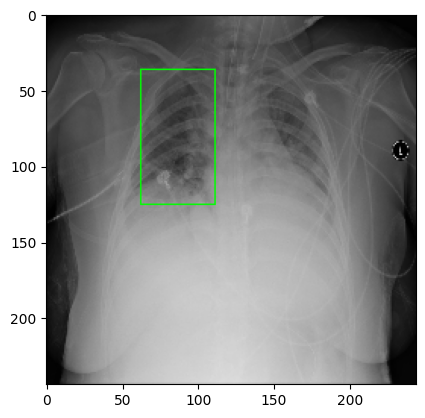

In [ ]:
datapath = 'rsna-pneumonia-detection-challenge\stage_2_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm'
temp_img = pydicom.dcmread(datapath).pixel_array
temp_box = [264.0, 152.0, 213.0, 379.0]

temp_img_formated, box = format_image(temp_img, temp_box)
print(box)
temp_color_img = cv.cvtColor(temp_img_formated, cv.COLOR_GRAY2RGB)

cv.rectangle(temp_color_img, box, (0, 255, 0), 1)

plt.imshow(temp_color_img)
# plt.axis("off")
plt.show()


Load labels and display first 5 rows.

In [15]:
train_labels = pd.read_csv('rsna-pneumonia-detection-challenge\stage_2_train_labels.csv')
train_labels.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


Creates and uses a function to load and process the DICOM images of Lung CTs and labels.

In [ ]:
def data_load(dataset, batch_size=3, full_data_path=r"rsna-pneumonia-detection-challenge\stage_2_train_images", image_ext=".dcm",ds_type='not_trian'):
    X = []
    Y = []

    for index, row in tqdm(dataset.iterrows(), total=len(dataset), desc="Loading data"):
        filename = row['patientId']

        temp_img = pydicom.dcmread(os.path.join(full_data_path, filename + image_ext)).pixel_array
        
        temp_box = [row['x'], row['y'], row['width'], row['height']] if not math.isnan(row['x']) else [0.0, 0.0, 0.0, 0.0]

        img, box = format_image(temp_img, temp_box)

        img = img.astype(float) / 255.
        box = np.asarray(box, dtype=float) / input_size

        label = np.append(box, row['Target'])

        X.append(img)
        Y.append(label)
    
    X = np.array(X)
    data_X_len = len(X)
    X = np.expand_dims(X, axis=3)
    X = tf.convert_to_tensor(X, dtype=tf.float32)
    Y = tf.convert_to_tensor(Y, dtype=tf.float32)
    
    result = tf.data.Dataset.from_tensor_slices((X, Y))

    return result,data_X_len
raw_train_ds,train_len = data_load(train_labels[:5200],ds_type="train")
print(train_len)
raw_valid_ds,valid_len = data_load(train_labels[5200:5900],ds_type="not train")
raw_test_ds, test_len = data_load(train_labels[5900:6501],ds_type="not train")

Loading data: 100%|██████████| 6001/6001 [03:00<00:00, 33.20it/s]


6001


Loading data: 100%|██████████| 200/200 [00:06<00:00, 29.03it/s]


Defines a function to ready the images, label pair to be used in TensorFlow.

In [18]:
CLASSES = 2

def format_instance(image, label):
    return image, (tf.one_hot(int(label[4]), CLASSES), [label[0], label[1], label[2], label[3]])

Defines a function to optimize the training dataset for the tensor flow model.

In [19]:
BATCH_SIZE = 32

def tune_training_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1024, reshuffle_each_iteration=True)
    dataset = dataset.repeat() # The dataset be repeated indefinitely.
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

Defines a function to optimize the validation dataset for the tensor flow model.

In [20]:
def tune_validation_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(len(dataset) // 4)
    dataset = dataset.repeat()
    return dataset

Using the above functions, preparing the training and validation datasets.

In [21]:
train_ds = tune_training_ds(raw_train_ds)
validation_ds = tune_validation_ds(raw_valid_ds)

Visualizing part of the training data set.

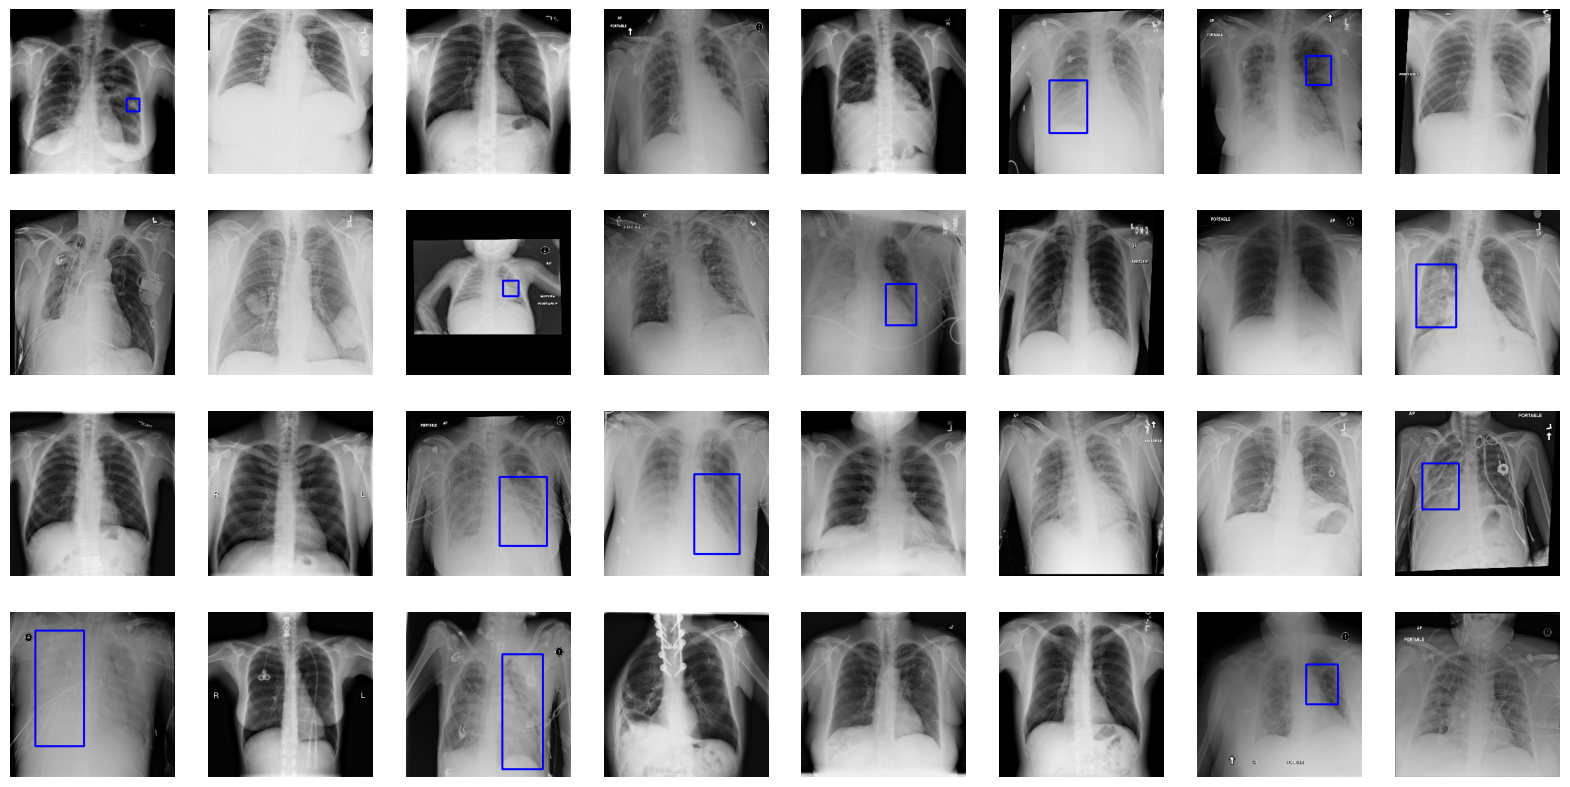

In [22]:
plt.figure(figsize=(20, 10))
for images, labels in train_ds.take(1):
    for i in range(BATCH_SIZE):
        # print(labels.shape)
        ax = plt.subplot(4, BATCH_SIZE//4, i + 1)
        label = labels[0][i]
        box = (labels[1][i] * input_size)
        box = tf.cast(box, tf.int32)

        image = images[i].numpy().astype("float") * 255.0
        image = image.astype(np.uint8)
        image_color = cv.cvtColor(image, cv.COLOR_GRAY2RGB)

        color = (0, 0, 255)
        if label[0] > 0:
            color = (0, 255, 0)

        cv.rectangle(image_color, box.numpy(), color, 2)

        plt.imshow(image_color)
        plt.axis("off")

Building model architecture to perform classification (detecting pneumonia) and bounding box regression (localizing pneumonia in X-ray images).


In [23]:
DROPOUT_FACTOR = 0.5

def build_feature_extractor(inputs):

    x = tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu', input_shape=(input_size, input_size, 1))(inputs)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(32, kernel_size=3, activation = 'relu')(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(64, kernel_size=3, activation = 'relu')(x)
    x = tf.keras.layers.Dropout(DROPOUT_FACTOR)(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    return x

def build_model_adaptor(inputs):
    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    return x

def build_classifier_head(inputs):
    return tf.keras.layers.Dense(CLASSES, activation='softmax', name = 'classifier_head')(inputs)

def build_regressor_head(inputs):
    return tf.keras.layers.Dense(units = 4, name = 'regressor_head')(inputs)

def build_model(inputs):
    
    feature_extractor = build_feature_extractor(inputs)

    model_adaptor = build_model_adaptor(feature_extractor)

    classification_head = build_classifier_head(model_adaptor)

    regressor_head = build_regressor_head(model_adaptor)

    model = tf.keras.Model(inputs = inputs, outputs = [classification_head, regressor_head])

    model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss = {'classifier_head' : 'categorical_crossentropy', 'regressor_head' : 'mse' }, 
              metrics = {'classifier_head' : 'accuracy', 'regressor_head' : 'mse' })

    return model

Initializing the model with the standardized image dimensions and displaying the model structure.

In [24]:
model = build_model(tf.keras.layers.Input(shape=(input_size, input_size, 1,)))

model.summary()

C:\Users\Sanan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 244, 244,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 242, 242,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d   │ (None, 121, 121,  │          0 │ conv2d[0][0]      │
│ (AveragePooling2D)  │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 119, 119,  │      4,640 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_1 │ (None, 59, 59,    │          0 │ conv2d_1[0][0]    │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 57, 57,    │     18,496 │ average_pooling2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 57, 57,    │          0 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_2 │ (None, 28, 28,    │          0 │ dropout[0][0]     │
│ (AveragePooling2D)  │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 50176)     │          0 │ average_pooling2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │  3,211,328 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier_head     │ (None, 2)         │        130 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ regressor_head      │ (None, 4)         │        260 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,235,014 (12.34 MB)

 Trainable params: 3,235,014 (12.34 MB)

 Non-trainable params: 0 (0.00 B)

Visualizing model strucutre in another way.

In [41]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


Training the model.

In [34]:
history = model.fit(train_ds,
                    steps_per_epoch=(6000 // BATCH_SIZE),
                    validation_data=validation_ds, validation_steps=1, 
                    epochs=20)

Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 71s 353ms/step - classifier_head_accuracy: 0.6064 - classifier_head_loss: 0.7186 - loss: 0.8150 - regressor_head_loss: 0.0964 - regressor_head_mse: 0.0964 - val_classifier_head_accuracy: 0.8133 - val_classifier_head_loss: 0.4109 - val_loss: 0.4363 - val_regressor_head_loss: 0.0254 - val_regressor_head_mse: 0.0254
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 69s 366ms/step - classifier_head_accuracy: 0.7541 - classifier_head_loss: 0.5289 - loss: 0.5670 - regressor_head_loss: 0.0381 - regressor_head_mse: 0.0381 - val_classifier_head_accuracy: 0.8400 - val_classifier_head_loss: 0.3581 - val_loss: 0.3762 - val_regressor_head_loss: 0.0181 - val_regressor_head_mse: 0.0181
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 60s 319ms/step - classifier_head_accuracy: 0.7665 - classifier_head_loss: 0.4990 - loss: 0.5339 - regressor_head_loss: 0.0349 - regressor_head_mse: 0.0349 - val_classifier_head_accuracy: 0.8400 - val_classifier_head_loss: 0.3719 - val_loss: 0.3907 - 

Visualizing the training and validation accuracy of your classification model across epochs.

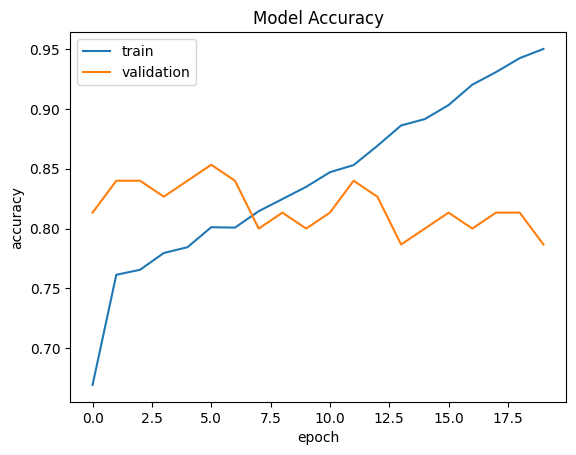

In [35]:
plt.plot(history.history['classifier_head_accuracy'])
plt.plot(history.history['val_classifier_head_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Defining function to calculate IoU.

In [36]:
def intersection_over_union(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])

    interWidth = max(0, xB - xA)
    interHeight = max(0, yB - yA)
    interArea = interWidth * interHeight

    boxAArea = boxA[2] * boxA[3] 
    boxBArea = boxB[2] * boxB[3]  


    if boxAArea == 0 or boxBArea == 0:
        return 0.0 


    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

Defining function to prepare the test data set for testing the model.

In [37]:
def tune_test_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(1) 
    dataset = dataset.repeat()
    return dataset

test_ds = tune_test_ds(raw_test_ds)

Visualizing test predicitons for the model along with the calculated IoU.

20


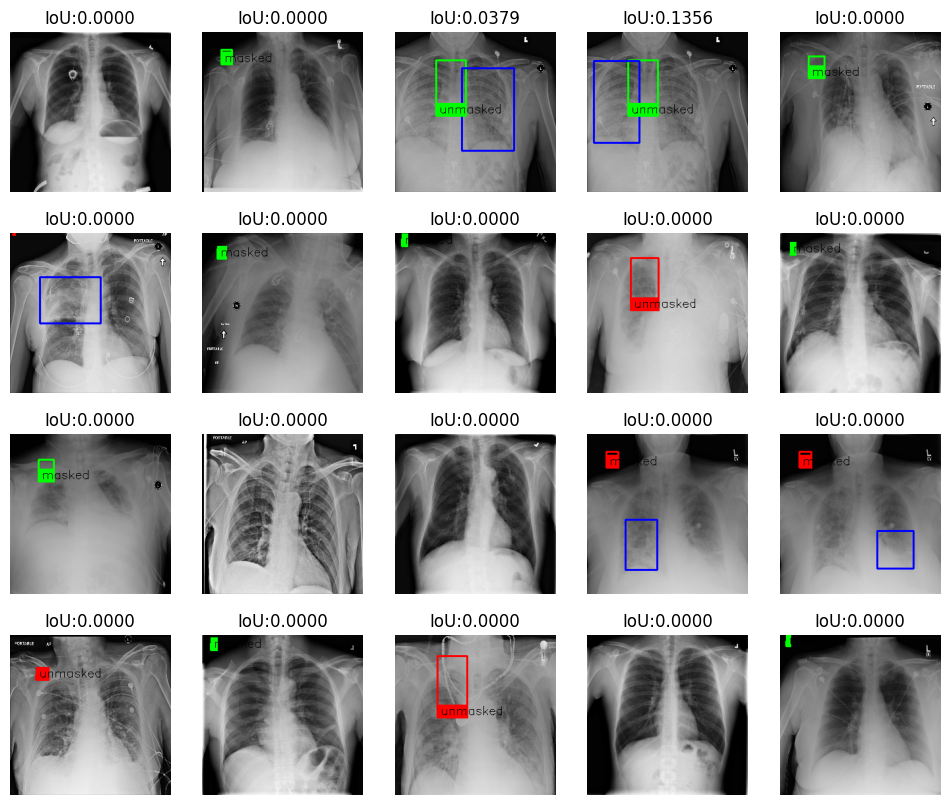

In [38]:
plt.figure(figsize=(12, 10))

test_list = list(test_ds.take(20).as_numpy_iterator())

print(len(test_list))

image, labels = test_list[0]

for i in range(len(test_list)):

    ax = plt.subplot(4, 5, i + 1)
    image, labels = test_list[i]

    predictions = model(image)

    predicted_box = predictions[1][0] * input_size
    predicted_box = tf.cast(predicted_box, tf.int32)

    predicted_label = predictions[0][0]

    image = image[0]

    actual_label = labels[0][0]
    actual_box = labels[1][0] * input_size
    actual_box = tf.cast(actual_box, tf.int32)

    image = image.astype("float") * 255.0
    image = image.astype(np.uint8)
    image_color = cv.cvtColor(image, cv.COLOR_GRAY2RGB)

    color = (255, 0, 0)
    # print box red if predicted and actual label do not match
    if (predicted_label[0] > 0.5 and actual_label[0] > 0) or (predicted_label[0] < 0.5 and actual_label[0] == 0):
        color = (0, 255, 0)

    img_label = "unmasked"
    if predicted_label[0] > 0.5:
        img_label = "masked"

    predicted_box_n = predicted_box.numpy()
    cv.rectangle(image_color, predicted_box_n, color, 2)
    cv.rectangle(image_color, actual_box.numpy(), (0, 0, 255), 2)
    cv.rectangle(image_color, (predicted_box_n[0], predicted_box_n[1] + predicted_box_n[3] - 20), (predicted_box_n[0] + predicted_box_n[2], predicted_box_n[1] + predicted_box_n[3]), color, -1)
    cv.putText(image_color, img_label, (predicted_box_n[0] + 5, predicted_box_n[1] + predicted_box_n[3] - 5), cv.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0))

    IoU = intersection_over_union(predicted_box.numpy(), actual_box.numpy())

    plt.title("IoU:" + format(IoU, '.4f'))
    plt.imshow(image_color)
    plt.axis("off")

A detailed evaluation pipeline to assess your trained model's predictions on 200 test samples, visualize bounding boxes, and calculate accuracy & Intersection over Union (IoU).

In [39]:
output_dir = "output_predictions"
os.makedirs(output_dir, exist_ok=True)

plt.figure(figsize=(12, 10))

test_list = list(test_ds.take(200).as_numpy_iterator())
print(f"Test Data Size: {len(test_list)}")

correct_count = 0
total_count = 0
iou_list = []

for i in range(len(test_list)):

    image, labels = test_list[i]
    predictions = model(image)

    predicted_box = predictions[1][0] * input_size
    predicted_box = tf.cast(predicted_box, tf.int32)
    predicted_label = predictions[0][0]

    image = image[0]
    actual_label = labels[0][0]
    actual_box = labels[1][0] * input_size
    actual_box = tf.cast(actual_box, tf.int32)

    image = image.astype("float") * 255.0
    image = image.astype(np.uint8)
    image_color = cv.cvtColor(image, cv.COLOR_GRAY2RGB)

    color = (255, 0, 0) 
    if (predicted_label[0] > 0.5 and actual_label[0] > 0) or (predicted_label[0] < 0.5 and actual_label[0] == 0):
        color = (0, 255, 0) 
        correct_count += 1

    total_count += 1
    
    img_label = "unmasked"
    if predicted_label[0] > 0.5:
        img_label = "masked"

    predicted_box_n = predicted_box.numpy()
    cv.rectangle(image_color, predicted_box_n, color, 2)
    cv.rectangle(image_color, actual_box.numpy(), (0, 0, 255), 2) 
    cv.rectangle(image_color, (predicted_box_n[0], predicted_box_n[1] + predicted_box_n[3] - 20), 
                 (predicted_box_n[0] + predicted_box_n[2], predicted_box_n[1] + predicted_box_n[3]), color, -1)
    cv.putText(image_color, img_label, (predicted_box_n[0] + 5, predicted_box_n[1] + predicted_box_n[3] - 5), 
               cv.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0))

    #IoU
    IoU = intersection_over_union(predicted_box.numpy(), actual_box.numpy())
    iou_list.append(IoU)

    output_path = os.path.join(output_dir, f"prediction_{i + 1}.png")
    cv.imwrite(output_path, cv.cvtColor(image_color, cv.COLOR_RGB2BGR)) 

accuracy = correct_count / total_count
average_iou = np.mean(iou_list)

print(f"Accuracy: {accuracy:.4f}")
print(f"Mean IoU: {average_iou:.4f}")

plt.savefig(os.path.join(output_dir, "all_predictions.png"))
plt.show()

Test Data Size: 200
Accuracy: 0.8200
Mean IoU: 0.0167


<Figure size 1200x1000 with 0 Axes>